In [1]:
try: # Install microgrids package in JupyterLite (if run in JupyterLite)
    import piplite
    await piplite.install(['numpy'])
except ImportError:
    pass

In [2]:
import random
import numpy as np
import math

In [3]:
load = [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]
sum(load)/len(load)

18.25

In [4]:
wind = [random.randint(2,15) for _ in range(24)]
#wind

In [5]:
# Generate 12 points between 0 and pi (half of the sine wave)
x = np.linspace(0, np.pi, 12)

# Apply the sine function to get a half-sinusoidal distribution
sinusoidal_values = np.sin(x)

# Normalize the values to a specific range if needed (optional)
# For example, scaling between 0 and 1
normalized_values = sinusoidal_values / np.max(sinusoidal_values)

# Peak Solar power is 20KW
solar = np.round(normalized_values * 20)
solar = [0] * 6 + solar.tolist() + [0] * 6
#solar

regenerate = [a + b for a, b in zip(wind, solar)]

In [6]:
print(f'Hourly regenerative power available is: {regenerate}')

Hourly regenerative power available is: [8, 13, 3, 13, 12, 3, 7.0, 21.0, 14.0, 23.0, 26.0, 25.0, 35.0, 27.0, 29.0, 21.0, 8.0, 4.0, 12, 7, 15, 12, 8, 5]


In [7]:
print(f'Hourly load for a day is: {load}')
# Base load generator
nuclear = 6

# Total green power generation available as sum of wind, solar, nuclear
available_supply = [green + nuclear for green in regenerate]
print(f'Available green power in microgrid is: {available_supply}')

# Power deficit is load minus available power
deficit_power = [a - b for a,b in zip(load, available_supply)]
print(f'Deficit in microgrid is: {deficit_power}')

# Initialize battery requirement
soc = sum(available_supply) - sum(load)
battery_capacity = 0
#cap = []

for reqd_power in deficit_power:
    if reqd_power < 0:
        soc -= reqd_power
    else:  # Charge the battery (excess in power)
        soc = max(soc - reqd_power, 0)  # Ensure no negative charge
    # Track the maximum battery capacity needed
    battery_capacity = max(battery_capacity, soc)
    #cap.append(soc)

battery_capacity -= sum(available_supply) - sum(load)
# Output the maximum battery capacity required
print(f'The battery capacity required is: {battery_capacity} kWh')
#print(cap)

Hourly load for a day is: [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]
Available green power in microgrid is: [14, 19, 9, 19, 18, 9, 13.0, 27.0, 20.0, 29.0, 32.0, 31.0, 41.0, 33.0, 35.0, 27.0, 14.0, 10.0, 18, 13, 21, 18, 14, 11]
Deficit in microgrid is: [4, -14, -4, -14, -13, -8, -6.0, -24.0, -16.0, -7.0, -8.0, -6.0, -15.0, -6.0, -7.0, 0.0, 9.0, 11.0, 14, 14, 13, 6, 11, 9]
The battery capacity required is: 144.0 kWh


In [8]:
# Introduce Storage to cater for deficit
print(f'Required Battery capacity: {battery_capacity}')
battery_charged = sum(available_supply) - sum(load)
soc = [round(battery_charged / battery_capacity, 2)]

wasted_power = []

for deficit in deficit_power:
    if deficit > 0:
        battery_charged -= deficit
        wasted_power.append(0)
    else:
        battery_charged -= deficit
        if battery_charged >= battery_capacity:
            wasted_power.append(battery_charged - battery_capacity)
            battery_charged = battery_capacity
        
    soc.append(round(battery_charged / battery_capacity, 2))

print(f'State of Battery Charge: {soc}')
print(f'Energy Wasted: {wasted_power}')

Required Battery capacity: 144.0
State of Battery Charge: [0.4, 0.37, 0.47, 0.49, 0.59, 0.68, 0.74, 0.78, 0.94, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94, 0.86, 0.76, 0.67, 0.58, 0.53, 0.46, 0.4]
Energy Wasted: [0, 8.0, 7.0, 8.0, 6.0, 15.0, 6.0, 7.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
print(f'Total load in a day: {sum(load)}')
print(f'Total generation in a day: {sum(available_supply)}')
print(f'Total of power not consumed: {sum(wasted_power)}')

Total load in a day: 438
Total generation in a day: 495.0
Total of power not consumed: 57.0


In [10]:
nuclear_max = 6
nuclear_minm = 4

battery_charged = sum(available_supply) - sum(load)
soc = [round(battery_charged / battery_capacity, 2)]

wasted_power = []


short = [a - b for (a,b) in zip(regenerate, load)]

In [11]:
print(regenerate)
print(load)
print(short)

[8, 13, 3, 13, 12, 3, 7.0, 21.0, 14.0, 23.0, 26.0, 25.0, 35.0, 27.0, 29.0, 21.0, 8.0, 4.0, 12, 7, 15, 12, 8, 5]
[18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]
[-10, 8, -2, 8, 7, 2, 0.0, 18.0, 10.0, 1.0, 2.0, 0.0, 9.0, 0.0, 1.0, -6.0, -15.0, -17.0, -20, -20, -19, -12, -17, -15]


In [12]:
# The goal is to simulate the power balance in a microgrid with solar, wind, nuclear, and battery storage based on a given load profile.
# We will follow these steps:
# 1. Adjust nuclear power to minimize excess energy when renewable generation exceeds load + battery charging capacity.
# 2. Track battery SOC (state of charge) throughout the day.
# 3. Ensure load is served by a combination of renewables, nuclear, and battery power.

# Given data
load_profile = np.array([18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20])
renewable_generation = np.array([13, 15, 5, 4, 13, 15, 9, 15, 23, 30, 33, 22, 35, 24, 22, 15, 17, 4, 2, 13, 2, 5, 10, 9])
battery_capacity = 163  # Total battery capacity
battery_soc = 0.37 * battery_capacity  # Initial state of charge (37% of capacity)
battery_max_charge_rate = 10  # Assume a maximum charge rate of 10 units/hour
battery_max_discharge_rate = 10  # Assume a maximum discharge rate of 10 units/hour
nuclear_min = 4  # Minimum nuclear power
nuclear_max = 8  # Maximum nuclear power

# To store results
nuclear_power_output = []
battery_soc_history = []
excess_energy_history = []

for hour in range(24):
    # Calculate the initial required nuclear power assuming no excess
    nuclear_power = max(nuclear_min, min(nuclear_max, load_profile[hour] - renewable_generation[hour]))
    
    # Check the total available generation (renewable + nuclear)
    total_generation = renewable_generation[hour] + nuclear_power
    
    # If generation exceeds load and battery charging, adjust nuclear to minimize excess
    excess_energy = total_generation - load_profile[hour]
    
    if excess_energy > 0:
        # Calculate the amount of energy that can be stored in the battery
        available_battery_capacity = battery_capacity - battery_soc
        charge_to_battery = min(excess_energy, available_battery_capacity, battery_max_charge_rate)
        battery_soc += charge_to_battery
        excess_energy -= charge_to_battery
        
        # Adjust nuclear power to minimize the remaining excess energy
        if excess_energy > 0:
            nuclear_power -= min(excess_energy, nuclear_power - nuclear_min)
    
    # If generation is less than the load, discharge battery if possible
    elif total_generation < load_profile[hour]:
        deficit_energy = load_profile[hour] - total_generation
        discharge_from_battery = min(deficit_energy, battery_soc, battery_max_discharge_rate)
        battery_soc -= discharge_from_battery
        deficit_energy -= discharge_from_battery
        
        # If there is still a deficit after battery discharge, increase nuclear power if possible
        if deficit_energy > 0:
            nuclear_power = min(nuclear_max, nuclear_power + deficit_energy)
    
    # Store the results for each hour
    nuclear_power_output.append(nuclear_power)
    battery_soc_history.append(battery_soc)
    excess_energy_history.append(excess_energy)

# Convert results to numpy arrays for easier analysis
# nuclear_power_output = np.array(nuclear_power_output)
# battery_soc_history = np.array(battery_soc_history)
# excess_energy_history = np.array(excess_energy_history)

print(f' Nuclear Power Generated: {nuclear_power_output}')
print(f' Battery State of Charge: {battery_soc_history}')
print(f' Excess charge history: {excess_energy_history}')


 Nuclear Power Generated: [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 8, 6, 8, 8, 8, 8, 8, 8, 8]
 Battery State of Charge: [60.31, 70.31, 74.31, 77.31, 87.31, 97.31, 103.31, 113.31, 123.31, 133.31, 143.31, 144.31, 154.31, 155.31, 155.31, 151.31, 151.31, 142.31, 132.31, 126.31, 116.31, 106.31, 99.31, 96.31]
 Excess charge history: [0, 4, 0, 0, 2, 8, 0, 6, 13, 2, 3, 0, 3, 0, 0, -4, 0, -9, -22, -6, -24, -11, -7, -3]


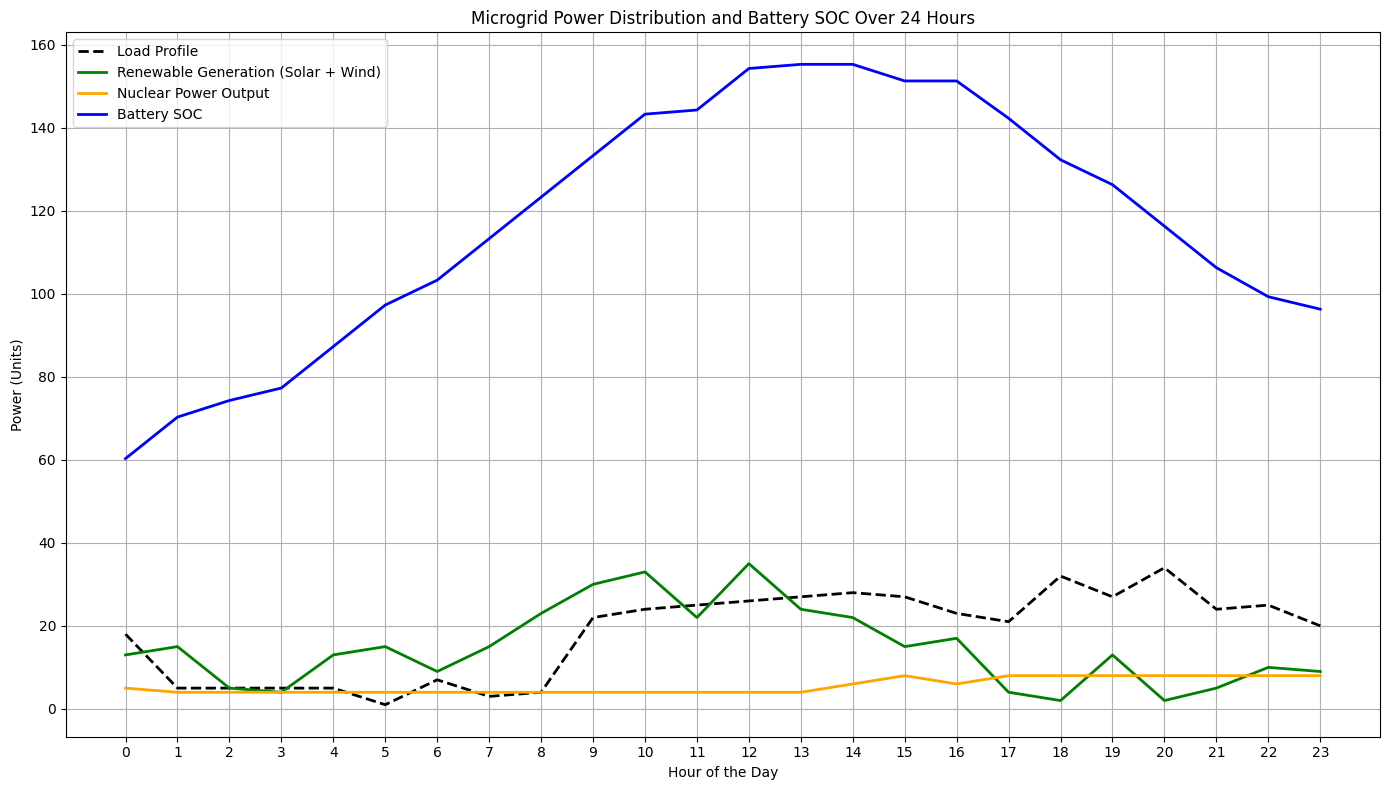

In [13]:
import matplotlib.pyplot as plt

# Time axis for the 24-hour period
hours = [i for i in range(len(load_profile))]

# Plot the load profile, renewable generation, and nuclear power output
plt.figure(figsize=(14, 8))

# Load Profile
plt.plot(hours, load_profile, label='Load Profile', color='black', linewidth=2, linestyle='--')
# Renewable Generation (Solar + Wind)
plt.plot(hours, renewable_generation, label='Renewable Generation (Solar + Wind)', color='green', linewidth=2)
# Nuclear Power Output
plt.plot(hours, nuclear_power_output, label='Nuclear Power Output', color='orange', linewidth=2)
# Battery SOC
plt.plot(hours, battery_soc_history, label='Battery SOC', color='blue', linewidth=2)

# Add grid, legend, and labels
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('Hour of the Day')
plt.ylabel('Power (Units)')
plt.title('Microgrid Power Distribution and Battery SOC Over 24 Hours')
plt.xticks(hours)  # Mark every hour

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
x = [i for i in range(24)]
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [15]:
import numpy as np

# Hourly load and regenerative power data
hourly_load = np.array([18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20])
regenerative_power = np.array([13, 6, 6, 9, 7, 14, 6.0, 15.0, 15.0, 24.0, 33.0, 25.0, 25.0, 33.0, 19.0, 19.0, 13.0, 4.0, 6, 8, 4, 2, 5, 9])

# Base load generator capacities
min_generator_output = 6  # kW
max_generator_output = 10  # kW

# Calculate energy deficit
energy_deficit = np.maximum(hourly_load - regenerative_power, 0)

# Calculate the energy contribution of the generator
generator_contribution = np.minimum(max_generator_output, energy_deficit)

# Adjust the generator output to cover the deficit within its range
remaining_deficit = np.maximum(energy_deficit - generator_contribution, 0)

# Calculate total remaining energy deficit (in kWh)
total_remaining_deficit = np.sum(remaining_deficit)  # Since each value is in kW and the duration is 1 hour

print(f"Total remaining energy deficit for the day: {total_remaining_deficit} kWh")

# Battery capacity is the remaining deficit that needs to be covered
battery_capacity = total_remaining_deficit
print(f"Required battery capacity: {battery_capacity} kWh")


Total remaining energy deficit for the day: 75.0 kWh
Required battery capacity: 75.0 kWh


In [16]:
import numpy as np

# Hourly load and regenerative power data
hourly_load = np.array([18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20])
regenerative_power = np.array([13, 6, 6, 9, 7, 14, 6.0, 15.0, 15.0, 24.0, 33.0, 25.0, 25.0, 33.0, 19.0, 19.0, 13.0, 4.0, 6, 8, 4, 2, 5, 9])

# Base load generator capacities
min_generator_output = 6  # kW
max_generator_output = 10  # kW

# Calculate energy deficit
energy_deficit = np.maximum(hourly_load - regenerative_power, 0)

# Calculate the generator's actual contribution for each hour
generator_contribution = np.minimum(max_generator_output, energy_deficit)
# Adjust generator output within its range
generator_contribution = np.maximum(generator_contribution, min_generator_output)

# Calculate the remaining deficit after accounting for the generator's contribution
remaining_deficit = np.maximum(energy_deficit - generator_contribution, 0)

# Calculate total remaining energy deficit (in kWh)
total_remaining_deficit = np.sum(remaining_deficit)  # Since each value is in kW and the duration is 1 hour

print(f"Total remaining energy deficit for the day: {total_remaining_deficit} kWh")

# Battery capacity is the remaining deficit that needs to be covered
battery_capacity = total_remaining_deficit
print(f"Required battery capacity: {battery_capacity} kWh")


Total remaining energy deficit for the day: 75.0 kWh
Required battery capacity: 75.0 kWh
